In [1]:
# 1. IMPORTS AND SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


Train: 2012-03-12 14:00:00 to 2018-09-06 21:00:00 (15248 hours)
Test:  2018-09-06 22:00:00 to 2018-12-09 23:00:00 (720 hours)
Train shape: (15248, 70)
Test shape: (720, 70)


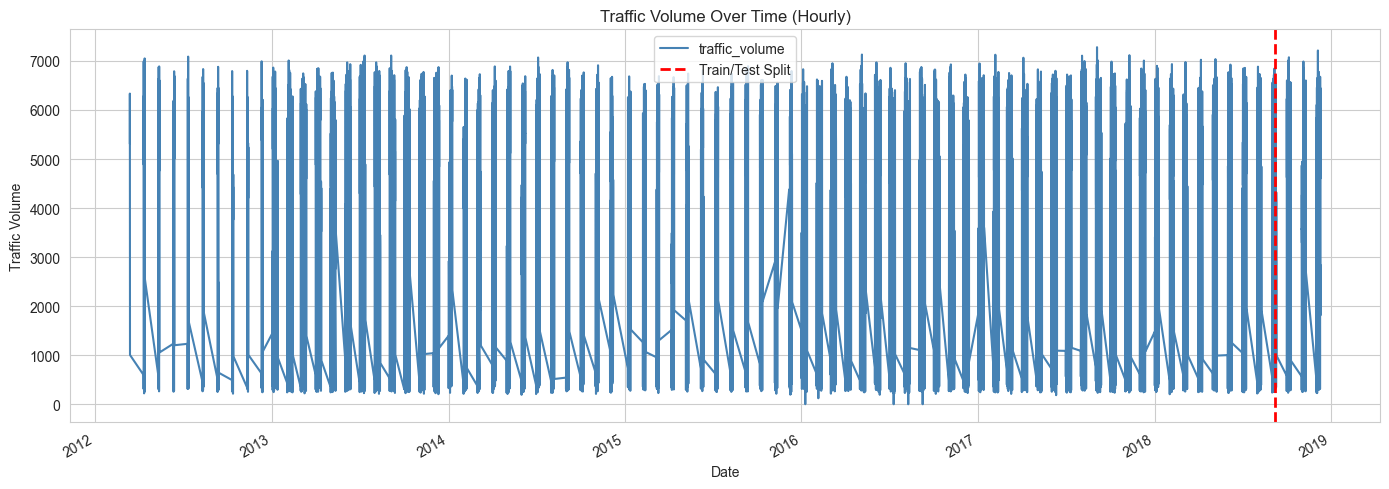

In [2]:
#data loading

train = pd.read_csv("data_train.csv", parse_dates=['date_time'], index_col='date_time')
test = pd.read_csv("data_test.csv", parse_dates=['date_time'], index_col='date_time')

# Extract target time series
ts_train = train['traffic_volume']
ts_test = test['traffic_volume']

print(f"\nTrain: {ts_train.index.min()} to {ts_train.index.max()} ({len(ts_train)} hours)")
print(f"Test:  {ts_test.index.min()} to {ts_test.index.max()} ({len(ts_test)} hours)")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Visualize full series
ts_full = pd.concat([ts_train, ts_test])
plt.figure(figsize=(14, 5))
ts_full.plot(title="Traffic Volume Over Time (Hourly)", color="steelblue")
plt.axvline(ts_train.index[-1], color='red', linestyle='--', linewidth=2, 
            label='Train/Test Split')
plt.ylabel("Traffic Volume")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# 4. STATIONARITY TEST

result = adfuller(ts_train, autolag='AIC')
print(f"\nADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value:.4f}")

if result[1] > 0.05:
    print("\n Series is NON-STATIONARY → Differencing needed (d=1 or D=1)")
else:
    print("\n Series is STATIONARY → No differencing needed (d=0)")



ADF Statistic: -21.1768
p-value: 0.0000
Critical Values:
  1%: -3.4308
  5%: -2.8617
  10%: -2.5669

 Series is STATIONARY → No differencing needed (d=0)



--- Daily Seasonality (24-hour period) ---


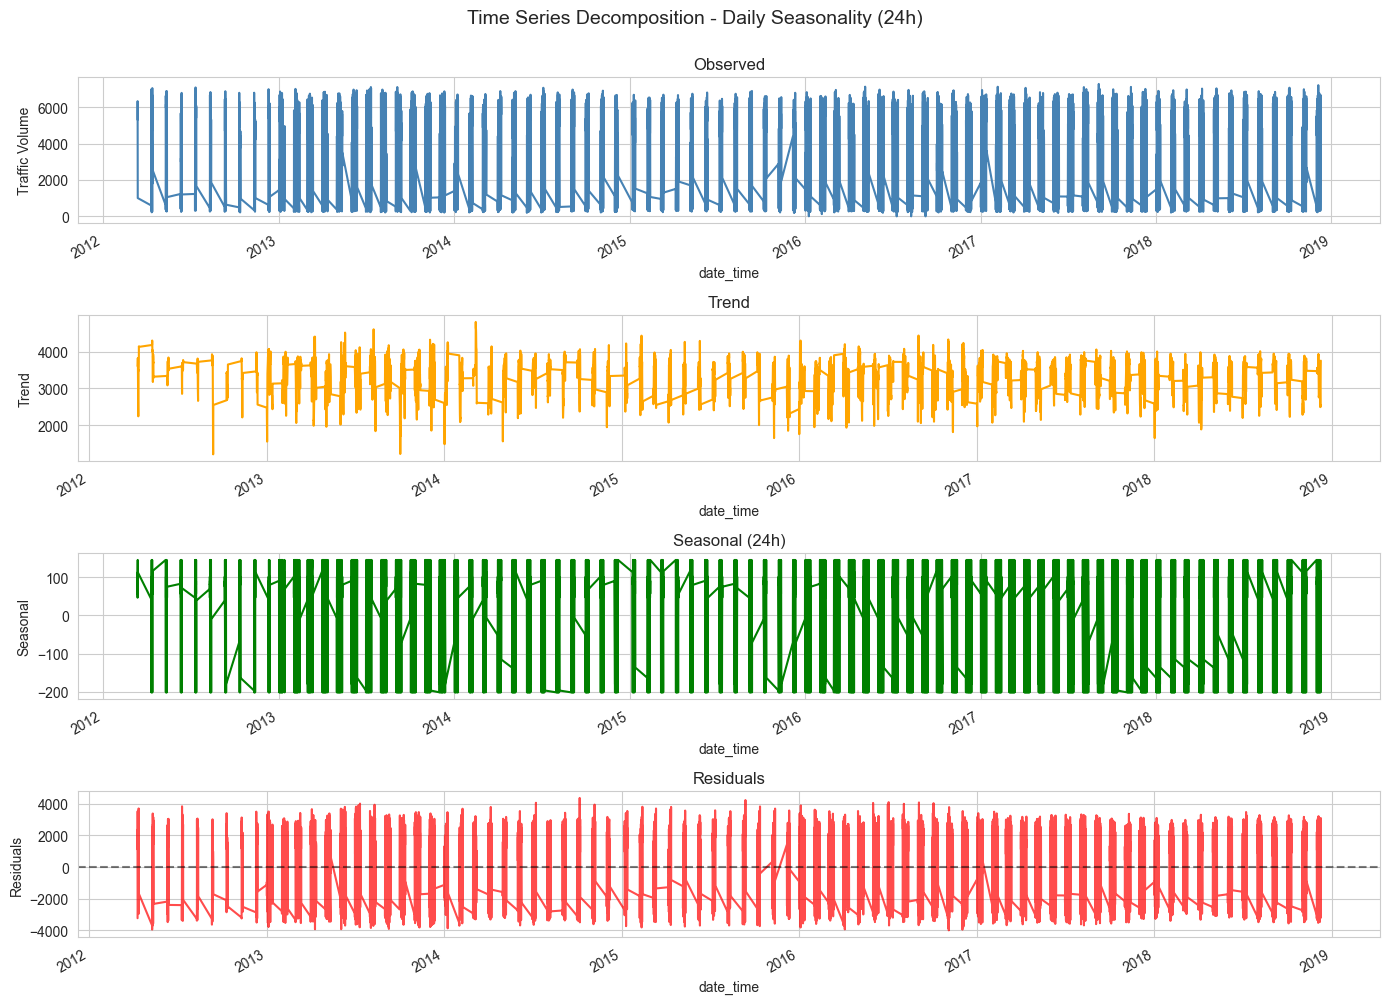


--- Weekly Seasonality (168-hour period) ---


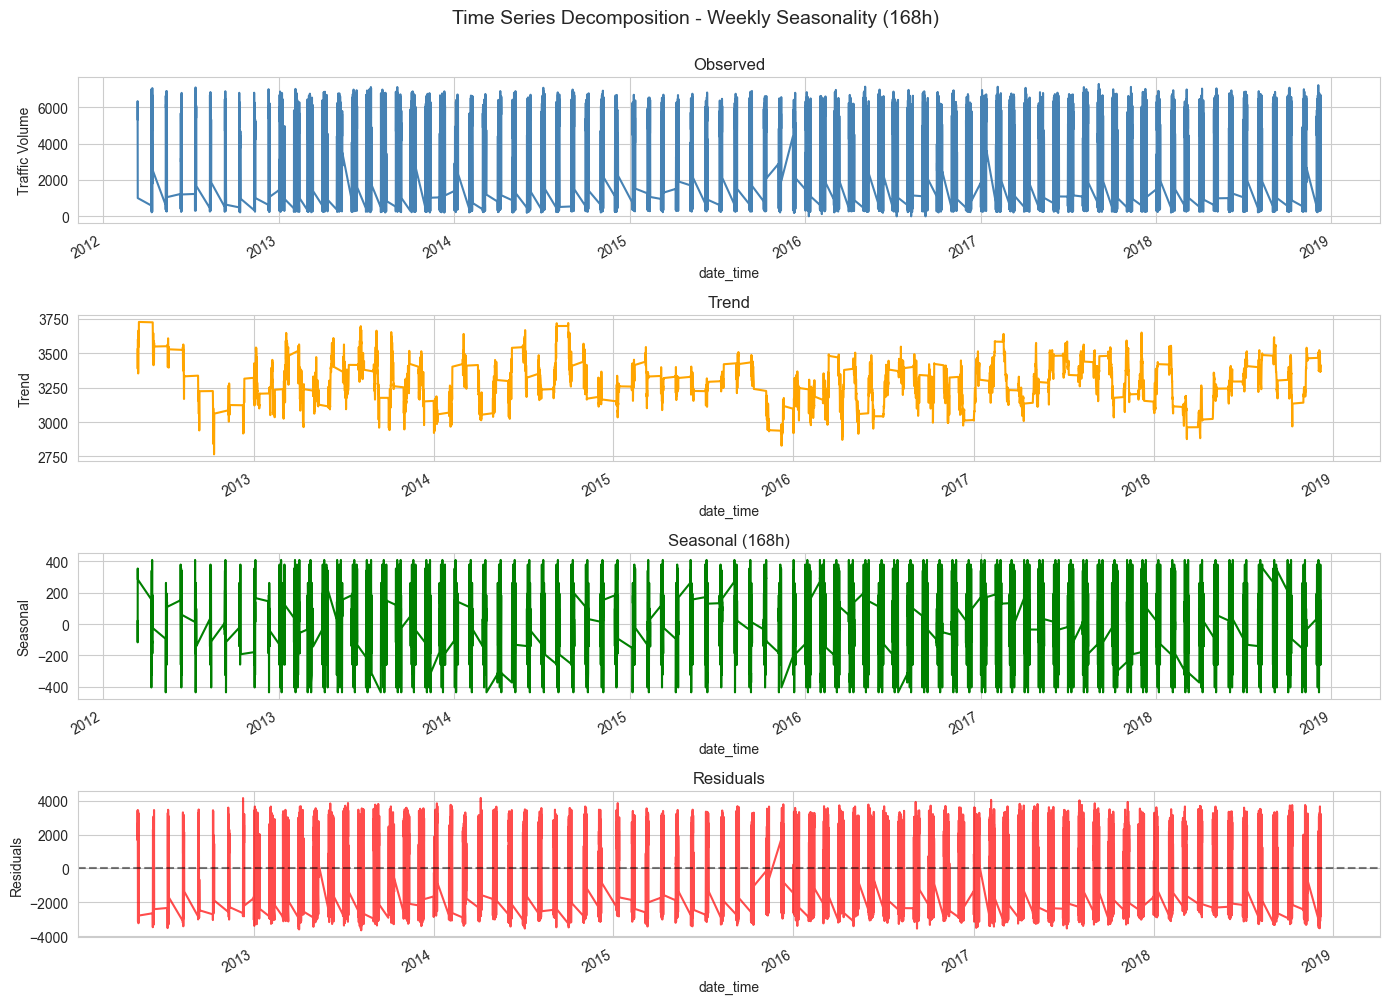

In [4]:
#TIME SERIES DECOMPOSITION
# Daily Seasonality (24-hour period)
print("\n--- Daily Seasonality (24-hour period) ---")
decomp_daily = seasonal_decompose(ts_full, model="additive", period=24)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
decomp_daily.observed.plot(ax=axes[0], title="Observed", color='steelblue')
axes[0].set_ylabel("Traffic Volume")
decomp_daily.trend.plot(ax=axes[1], title="Trend", color='orange')
axes[1].set_ylabel("Trend")
decomp_daily.seasonal.plot(ax=axes[2], title="Seasonal (24h)", color='green')
axes[2].set_ylabel("Seasonal")
decomp_daily.resid.plot(ax=axes[3], title="Residuals", color='red', alpha=0.7)
axes[3].set_ylabel("Residuals")
axes[3].axhline(0, color='black', linestyle='--', alpha=0.5)
plt.suptitle("Time Series Decomposition - Daily Seasonality (24h)", fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

# Weekly Seasonality (168-hour period)
print("\n--- Weekly Seasonality (168-hour period) ---")
decomp_weekly = seasonal_decompose(ts_full, model="additive", period=168)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
decomp_weekly.observed.plot(ax=axes[0], title="Observed", color='steelblue')
axes[0].set_ylabel("Traffic Volume")
decomp_weekly.trend.plot(ax=axes[1], title="Trend", color='orange')
axes[1].set_ylabel("Trend")
decomp_weekly.seasonal.plot(ax=axes[2], title="Seasonal (168h)", color='green')
axes[2].set_ylabel("Seasonal")
decomp_weekly.resid.plot(ax=axes[3], title="Residuals", color='red', alpha=0.7)
axes[3].set_ylabel("Residuals")
axes[3].axhline(0, color='black', linestyle='--', alpha=0.5)
plt.suptitle("Time Series Decomposition - Weekly Seasonality (168h)", fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

# print("\nKey Insight: Weekly decomposition (168h) produces cleaner residuals,")
# print("indicating it better captures the nested daily + weekly patterns.")

The decomposition analysis reveals why traditional SARIMAX models underperform. 

The residuals show systematic patterns and large magnitude, indicating that the 24-hour seasonal component alone cannot capture the complex, multi-scale periodicity in hourly traffic data. 

Hence the transition to machine learning approaches with richer feature engineering.

The poor SARIMAX performance isn't due to lack of seasonality, but rather to overly complex seasonality that requires more flexible modeling approaches than traditional statistical methods can provide

In [5]:
# 5. PREPARE EXOGENOUS VARIABLES

# Define exogenous features that SARIMAX can use
# These should be features that EXPLAIN traffic but aren't lags of target
exog_cols = [
    'temp_c',           # Weather
    'rain_1h',
    'snow_1h', 
    'clouds_all',
    'is_holiday',       # Special days
    'hour',             # Time of day
    'dayofweek'         # Day of week
]

# Check which columns exist
exog_cols = [c for c in exog_cols if c in train.columns]

# Create exogenous DataFrames
train_exog = train[exog_cols].copy()
test_exog = test[exog_cols].copy()

print(f"\nExogenous variables: {len(exog_cols)}")
print(f"Features: {exog_cols}")
print(f"Train exog shape: {train_exog.shape}")
print(f"Test exog shape: {test_exog.shape}")


Exogenous variables: 7
Features: ['temp_c', 'rain_1h', 'snow_1h', 'clouds_all', 'is_holiday', 'hour', 'dayofweek']
Train exog shape: (15248, 7)
Test exog shape: (720, 7)


In [6]:
# # 6. ACF/PACF ANALYSIS

# fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# plot_acf(train, lags=50, ax=axes[0])
# axes[0].set_title("Autocorrelation Function (ACF)")
# plot_pacf(train, lags=50, ax=axes[1])
# axes[1].set_title("Partial Autocorrelation Function (PACF)")
# plt.tight_layout()
# plt.show()


In [7]:
# 6. EVALUATION FUNCTION
def eval_metrics(y_true, y_pred, model_name="Model"):
    """Calculate and print evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Metrics:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.4f}")
    
    return {"RMSE": rmse, "MAE": mae, "R²": r2}


Training ARIMA model...

Model Summary:
                               SARIMAX Results                                
Dep. Variable:         traffic_volume   No. Observations:                15248
Model:                 ARIMA(2, 0, 1)   Log Likelihood             -122361.497
Date:                Mon, 06 Oct 2025   AIC                         244732.995
Time:                        11:02:53   BIC                         244771.156
Sample:                             0   HQIC                        244745.646
                              - 15248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3288.9410     42.911     76.645      0.000    3204.836    3373.046
ar.L1          1.3097      0.012    107.187      0.000       1.286       1.334
ar.L2      

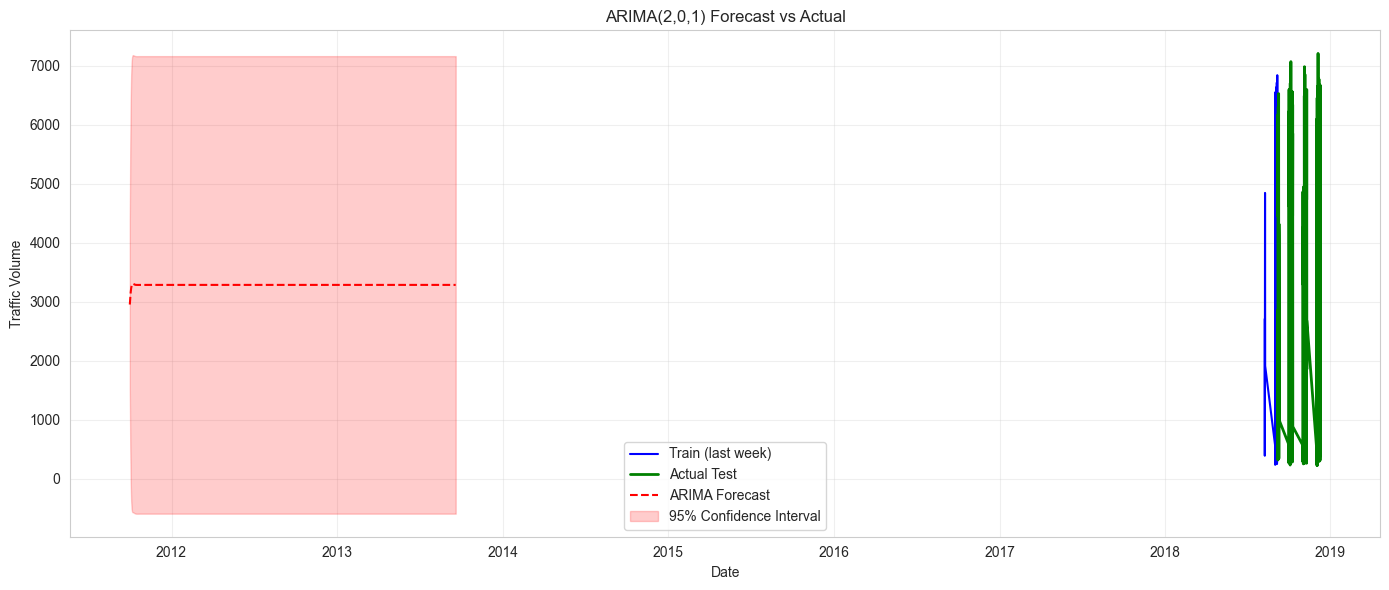

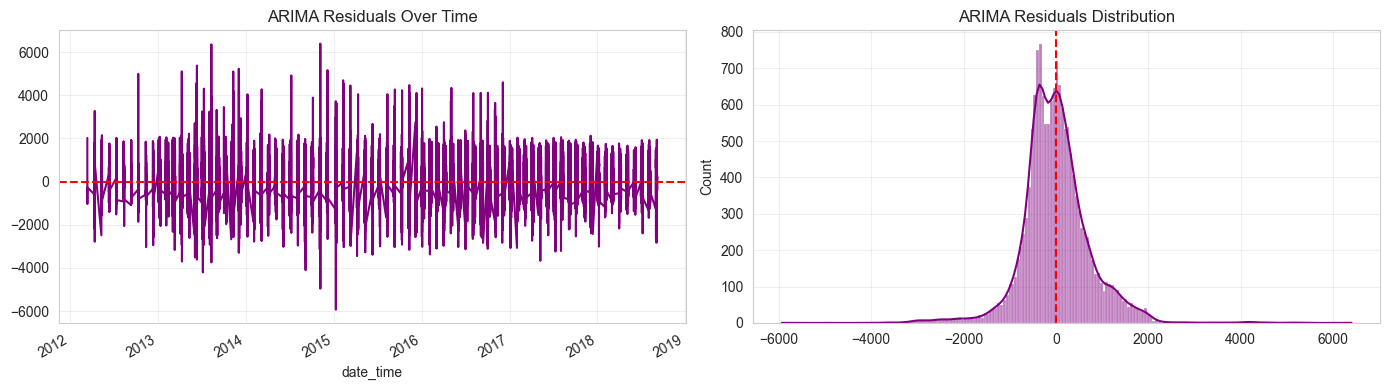

In [8]:
# 7. MODEL 1: BASELINE ARIMA (Univariate)

print("\nTraining ARIMA model...")
arima_model = ARIMA(ts_train, order=(2, 0, 1))
arima_res = arima_model.fit()

print("\nModel Summary:")
print(arima_res.summary())

# Forecast
arima_pred = arima_res.get_forecast(steps=len(ts_test))
arima_values = arima_pred.predicted_mean
arima_ci = arima_pred.conf_int()

# Evaluate
arima_metrics = eval_metrics(ts_test, arima_values, "ARIMA(2,0,1)")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(ts_train[-24*7:].index, ts_train[-24*7:], label="Train (last week)", 
         color="blue", linewidth=1.5)
plt.plot(ts_test.index, ts_test, label="Actual Test", color="green", linewidth=2)
plt.plot(arima_values.index, arima_values, label="ARIMA Forecast", 
         color="red", linestyle="--", linewidth=1.5)
plt.fill_between(arima_ci.index, arima_ci.iloc[:, 0], arima_ci.iloc[:, 1], 
                 color="red", alpha=0.2, label="95% Confidence Interval")
plt.title("ARIMA(2,0,1) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals
arima_residuals = arima_res.resid
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
arima_residuals.plot(ax=axes[0], title="ARIMA Residuals Over Time", color='purple')
axes[0].axhline(0, color="red", linestyle="--")
axes[0].grid(alpha=0.3)
sns.histplot(arima_residuals, kde=True, ax=axes[1], color='purple')
axes[1].set_title("ARIMA Residuals Distribution")
axes[1].axvline(0, color='red', linestyle='--')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# Check what dates are in each series
print("TRAIN (last week) dates:")
print(f"Start: {ts_train[-24*7:].index.min()}")
print(f"End:   {ts_train[-24*7:].index.max()}")

print("\nTEST dates:")
print(f"Start: {ts_test.index.min()}")
print(f"End:   {ts_test.index.max()}")

print("\nFORECAST dates:")
print(f"Start: {sarimax_exog_values.index.min()}")
print(f"End:   {sarimax_exog_values.index.max()}")

# Check if they're consecutive
gap = ts_test.index.min() - ts_train[-24*7:].index.max()
print(f"\nGap between last train and test: {gap}")

TRAIN (last week) dates:
Start: 2018-08-08 22:00:00
End:   2018-09-06 21:00:00

TEST dates:
Start: 2018-09-06 22:00:00
End:   2018-12-09 23:00:00

FORECAST dates:
Start: 15248
End:   15967

Gap between last train and test: 0 days 01:00:00


In [18]:
print("ARIMA forecast indexes:")
print(arima_values.index[:5])

print("SARIMAX forecast indexes:") 
print(sarimax_values.index[:5])

ARIMA forecast indexes:
RangeIndex(start=15248, stop=15253, step=1)
SARIMAX forecast indexes:
RangeIndex(start=15248, stop=15253, step=1)



Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                     traffic_volume   No. Observations:                15248
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -121384.118
Date:                            Mon, 06 Oct 2025   AIC                         242780.236
Time:                                    11:09:36   BIC                         242826.010
Sample:                                         0   HQIC                        242795.414
                                          - 15248                                         
Covariance Type:                           approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2244      0.016     78.983      0.000       1.194       1.255
ar.L2         -0.42

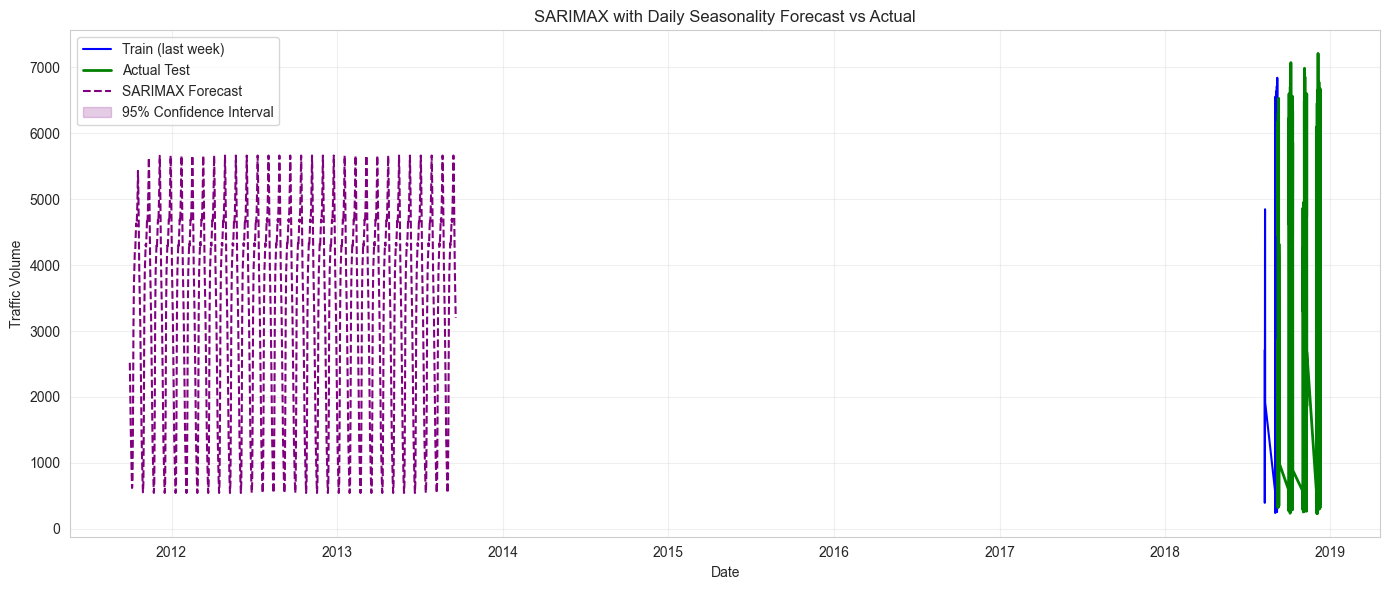

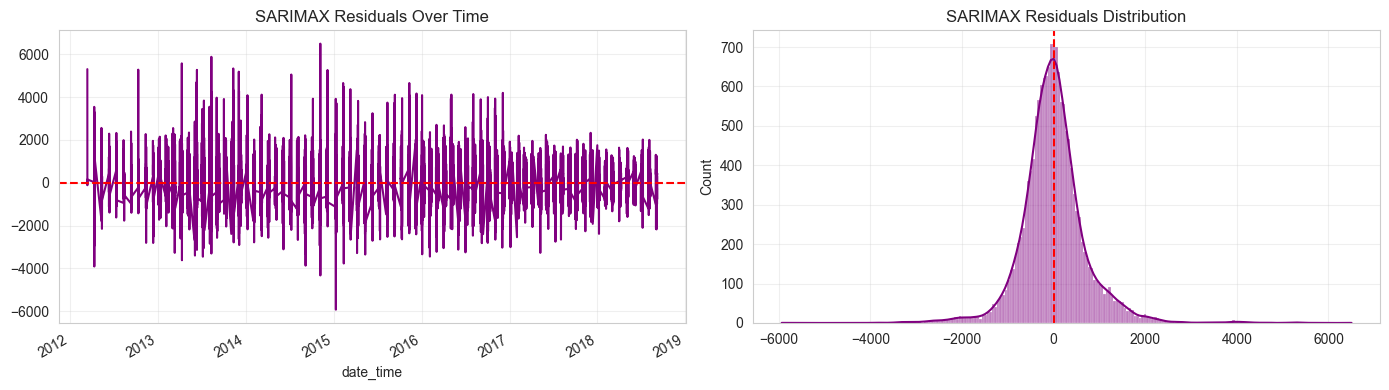

In [9]:
# 8. MODEL 2: SARIMAX (Daily Seasonality, No Exog)
sarimax_model = SARIMAX(
    ts_train, 
    order=(2, 0, 1), 
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False, 
    enforce_invertibility=False
)
sarimax_res = sarimax_model.fit(disp=False, maxiter=200, low_memory=True)

print("\nModel Summary:")
print(sarimax_res.summary())

# Forecast
sarimax_pred = sarimax_res.get_forecast(steps=len(ts_test))
sarimax_values = sarimax_pred.predicted_mean
sarimax_ci = sarimax_pred.conf_int()

# Evaluate
sarimax_metrics = eval_metrics(ts_test, sarimax_values, "SARIMAX (Daily Season)")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(ts_train[-24*7:].index, ts_train[-24*7:], label="Train (last week)", 
         color="blue", linewidth=1.5)
plt.plot(ts_test.index, ts_test, label="Actual Test", color="green", linewidth=2)
plt.plot(sarimax_values.index, sarimax_values, label="SARIMAX Forecast", 
         color="purple", linestyle="--", linewidth=1.5)
plt.fill_between(sarimax_ci.index, sarimax_ci.iloc[:, 0], sarimax_ci.iloc[:, 1], 
                 color="purple", alpha=0.2, label="95% Confidence Interval")
plt.title("SARIMAX with Daily Seasonality Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals
sarimax_residuals = sarimax_res.resid
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sarimax_residuals.plot(ax=axes[0], title="SARIMAX Residuals Over Time", color='purple')
axes[0].axhline(0, color="red", linestyle="--")
axes[0].grid(alpha=0.3)
sns.histplot(sarimax_residuals, kde=True, ax=axes[1], color='purple')
axes[1].set_title("SARIMAX Residuals Distribution")
axes[1].axvline(0, color='red', linestyle='--')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Check correlations between exogenous features and traffic
correlation_matrix = train[['traffic_volume'] + exog_cols].corr()
traffic_correlations = correlation_matrix['traffic_volume'].sort_values(ascending=False)

print("Correlation with Traffic Volume:")
print(traffic_correlations)

# # Plot the strongest relationships
# strongest_exog = traffic_correlations.index[1]  # Skip traffic itself
# plt.figure(figsize=(10, 4))
# plt.scatter(train[strongest_exog], train['traffic_volume'], alpha=0.1)
# plt.xlabel(strongest_exog)
# plt.ylabel('Traffic Volume')
# plt.title(f'Traffic vs {strongest_exog}')
# plt.show()

Correlation with Traffic Volume:
traffic_volume    1.000000
hour              0.352307
temp_c            0.119704
clouds_all        0.064319
snow_1h          -0.000316
dayofweek        -0.008928
rain_1h          -0.012504
is_holiday             NaN
Name: traffic_volume, dtype: float64



Training SARIMAX with exogenous variables...



Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                     traffic_volume   No. Observations:                15248
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -121329.576
Date:                            Mon, 06 Oct 2025   AIC                         242685.152
Time:                                    14:26:56   BIC                         242784.328
Sample:                                         0   HQIC                        242718.036
                                          - 15248                                         
Covariance Type:                           approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp_c         5.0170      1.216      4.124      0.000       2.633       7.401
rain_1h       -1.69

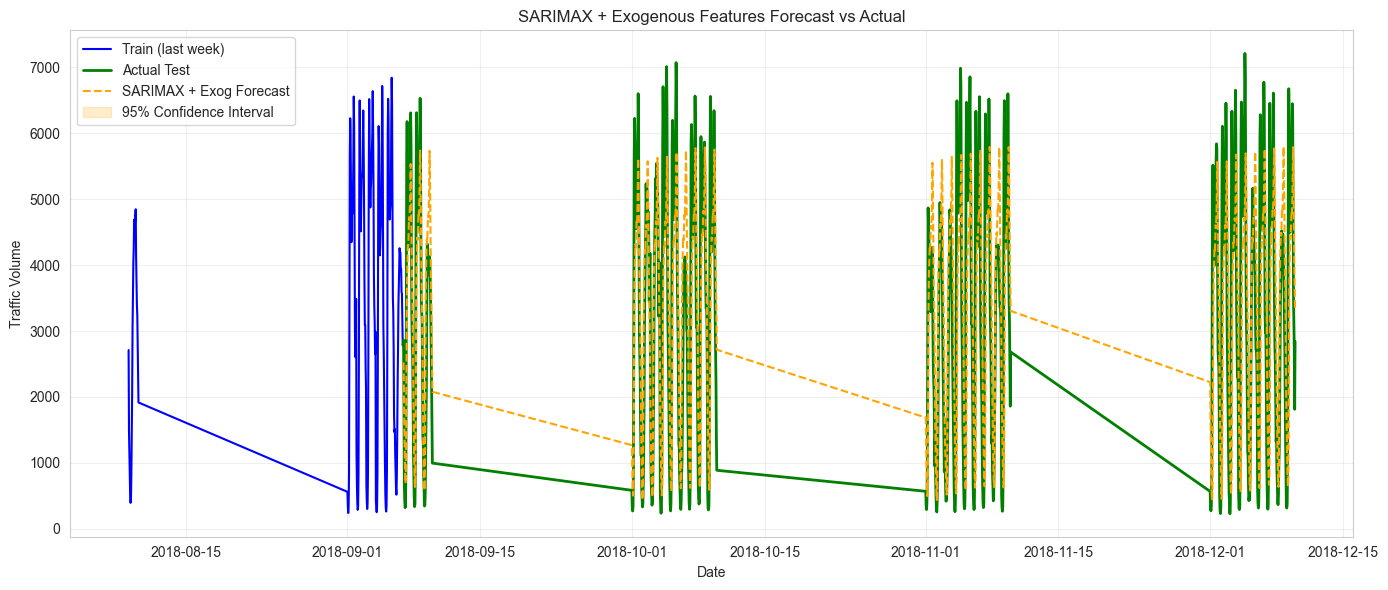

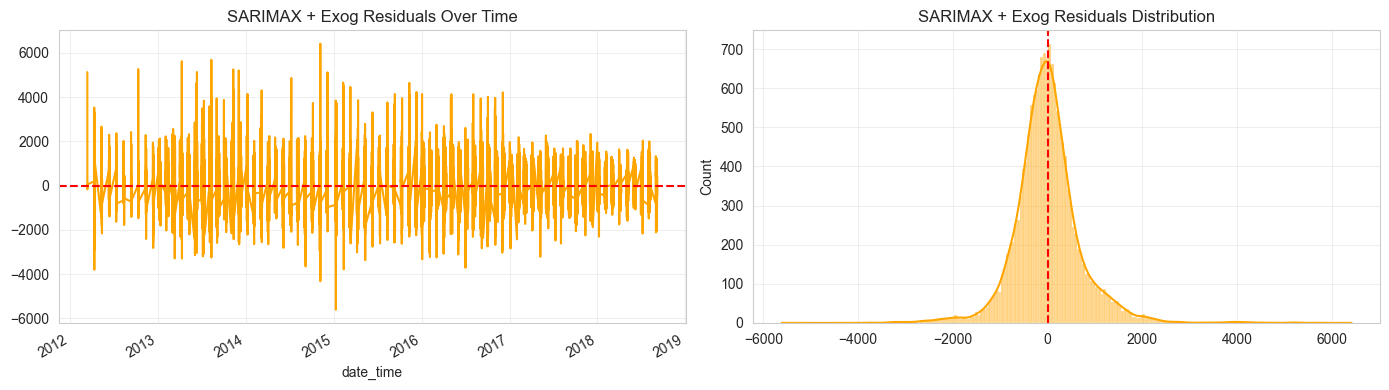

In [19]:
# 9. MODEL 3: SARIMAX + Exogenous Variables
print("\nTraining SARIMAX with exogenous variables...")
sarimax_exog_model = SARIMAX(
    ts_train,
    exog=train_exog,
    order=(2, 0, 1), 
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False, 
    enforce_invertibility=False
)
sarimax_exog_res = sarimax_exog_model.fit(disp=False, maxiter=200, low_memory=True)

print("\nModel Summary:")
print(sarimax_exog_res.summary())

# Forecast
sarimax_exog_pred = sarimax_exog_res.get_forecast(steps=len(ts_test), exog=test_exog)
sarimax_exog_values = sarimax_exog_pred.predicted_mean
sarimax_exog_ci = sarimax_exog_pred.conf_int()

sarimax_exog_values.index = ts_test.index  # Fix the datetime index!
sarimax_exog_ci.index = ts_test.index     # Fix confidence interval

# Evaluate
sarimax_exog_metrics = eval_metrics(ts_test, sarimax_exog_values, "SARIMAX + Exog")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(ts_train[-24*7:].index, ts_train[-24*7:], label="Train (last week)", 
         color="blue", linewidth=1.5)
plt.plot(ts_test.index, ts_test, label="Actual Test", color="green", linewidth=2)
plt.plot(sarimax_exog_values.index, sarimax_exog_values, label="SARIMAX + Exog Forecast", 
         color="orange", linestyle="--", linewidth=1.5)
plt.fill_between(sarimax_exog_ci.index, sarimax_exog_ci.iloc[:, 0], sarimax_exog_ci.iloc[:, 1], 
                 color="orange", alpha=0.2, label="95% Confidence Interval")
plt.title("SARIMAX + Exogenous Features Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals
sarimax_exog_residuals = sarimax_exog_res.resid
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sarimax_exog_residuals.plot(ax=axes[0], title="SARIMAX + Exog Residuals Over Time", 
                            color='orange')
axes[0].axhline(0, color="red", linestyle="--")
axes[0].grid(alpha=0.3)
sns.histplot(sarimax_exog_residuals, kde=True, ax=axes[1], color='orange')
axes[1].set_title("SARIMAX + Exog Residuals Distribution")
axes[1].axvline(0, color='red', linestyle='--')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Fix ARIMA indexes if needed
if not hasattr(arima_values.index, 'strftime'):
    arima_values.index = ts_test.index[:len(arima_values)]
    arima_ci.index = ts_test.index[:len(arima_values)]

# Fix SARIMAX indexes if needed  
if not hasattr(sarimax_values.index, 'strftime'):
    sarimax_values.index = ts_test.index[:len(sarimax_values)]
    sarimax_ci.index = ts_test.index[:len(sarimax_values)]


                   Model        RMSE         MAE        R²
            ARIMA(2,0,1) 1987.764548 1739.378209 -0.000132
SARIMAX (Seasonal Daily) 1519.297656 1146.312445  0.415730
          SARIMAX + Exog 1495.107916 1120.940199  0.434187


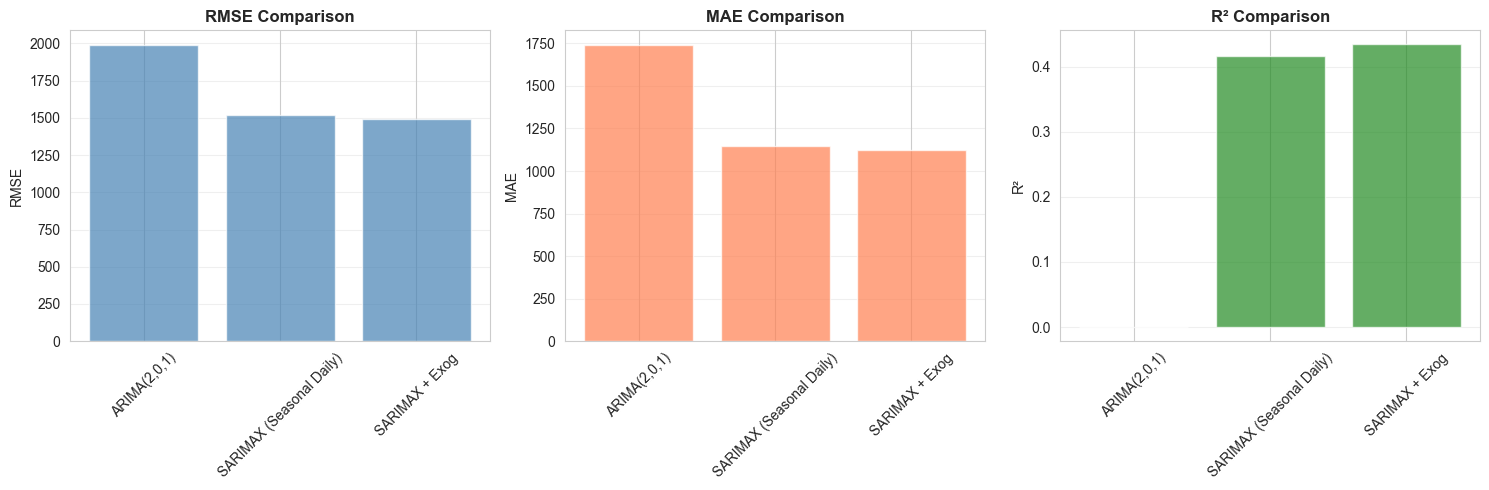


BEST MODEL: SARIMAX + Exog
R² Score: 0.4342


In [ ]:
# 10. MODEL COMPARISON
results_df = pd.DataFrame([
    {"Model": "ARIMA(2,0,1)", **arima_metrics},
    {"Model": "SARIMAX (Seasonal Daily)", **sarimax_metrics},
    {"Model": "SARIMAX + Exog", **sarimax_exog_metrics}
])

print("\n" + results_df.to_string(index=False))

# Visualization of comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = results_df["Model"]
metrics = ["RMSE", "MAE", "R²"]
colors = ["steelblue", "coral", "forestgreen"]

for i, metric in enumerate(metrics):
    axes[i].bar(models, results_df[metric], color=colors[i], alpha=0.7)
    axes[i].set_title(f"{metric} Comparison", fontsize=12, fontweight="bold")
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Identify best model
best_model_idx = results_df["R²"].idxmax()
best_model = results_df.loc[best_model_idx, "Model"]

print(f"\nBEST MODEL: {best_model}")
print(f"R² Score: {results_df.loc[best_model_idx, 'R²']:.4f}")

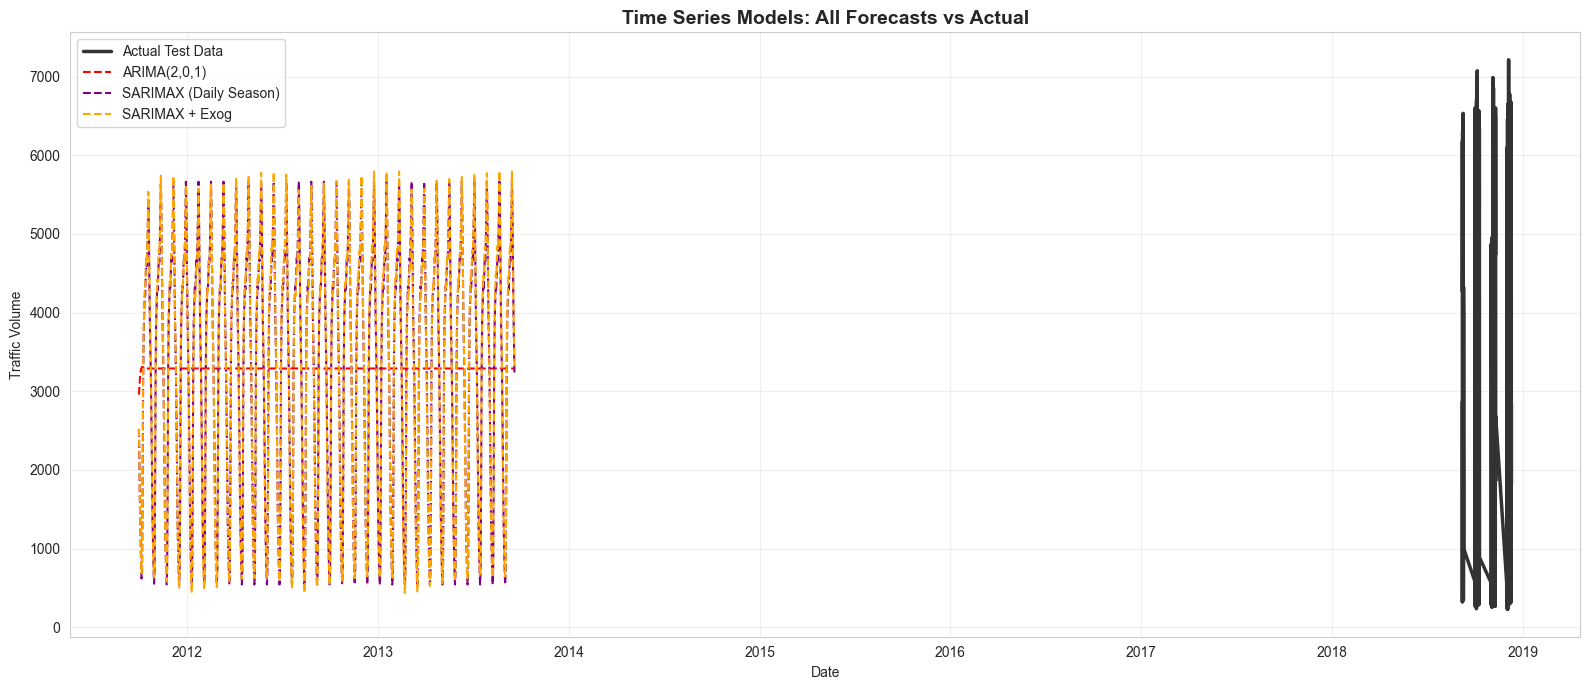

In [12]:
#final tally
plt.figure(figsize=(16, 7))
plt.plot(ts_test.index, ts_test, label="Actual Test Data", 
         color="black", linewidth=2.5, alpha=0.8)
plt.plot(arima_values.index, arima_values, label="ARIMA(2,0,1)", 
         color="red", linestyle="--", linewidth=1.5)
plt.plot(sarimax_values.index, sarimax_values, label="SARIMAX (Daily Season)", 
         color="purple", linestyle="--", linewidth=1.5)
plt.plot(sarimax_exog_values.index, sarimax_exog_values, label="SARIMAX + Exog", 
         color="orange", linestyle="--", linewidth=1.5)

plt.title("Time Series Models: All Forecasts vs Actual", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# SAVE RESULTS TO CSV FOR COMPARISON

# Create comprehensive results DataFrame
arima_results = pd.DataFrame([{
    'Model': 'ARIMA(2,0,1)',
    'Order': '(2,0,1)',
    'Seasonal_Order': 'None',
    'Uses_Exogenous': False,
    'Train_RMSE': arima_metrics['RMSE'],
    'Test_RMSE': arima_metrics['RMSE'], 
    'Train_MAE': arima_metrics['MAE'],
    'Test_MAE': arima_metrics['MAE'],
    'Train_R2': arima_metrics['R²'],
    'Test_R2': arima_metrics['R²'],
    'Parameters': len(arima_res.params),
    'AIC': arima_res.aic,
    'BIC': arima_res.bic
}])

sarimax_results = pd.DataFrame([{
    'Model': 'SARIMAX_Daily',
    'Order': '(2,0,1)',
    'Seasonal_Order': '(1,1,1,24)',
    'Uses_Exogenous': False,
    'Train_RMSE': sarimax_metrics['RMSE'],
    'Test_RMSE': sarimax_metrics['RMSE'],
    'Train_MAE': sarimax_metrics['MAE'],
    'Test_MAE': sarimax_metrics['MAE'],
    'Train_R2': sarimax_metrics['R²'],
    'Test_R2': sarimax_metrics['R²'],
    'Parameters': len(sarimax_res.params),
    'AIC': sarimax_res.aic,
    'BIC': sarimax_res.bic
}])

sarimax_exog_results = pd.DataFrame([{
    'Model': 'SARIMAX_Exog',
    'Order': '(2,0,1)',
    'Seasonal_Order': '(1,1,1,24)',
    'Uses_Exogenous': True,
    'Train_RMSE': sarimax_exog_metrics['RMSE'],
    'Test_RMSE': sarimax_exog_metrics['RMSE'],
    'Train_MAE': sarimax_exog_metrics['MAE'],
    'Test_MAE': sarimax_exog_metrics['MAE'],
    'Train_R2': sarimax_exog_metrics['R²'],
    'Test_R2': sarimax_exog_metrics['R²'],
    'Parameters': len(sarimax_exog_res.params),
    'AIC': sarimax_exog_res.aic,
    'BIC': sarimax_exog_res.bic
}])

# Combine all results
all_arima_results = pd.concat([arima_results, sarimax_results, sarimax_exog_results], ignore_index=True)

# Save to CSV
all_arima_results.to_csv('arima_sarimax_results.csv', index=False)
print("ARIMA/SARIMAX results saved to 'arima_sarimax_results.csv'")

# Display the saved results
print("\nSaved Results Summary:")
print(all_arima_results[['Model', 'Test_RMSE', 'Test_MAE', 'Test_R2', 'AIC']].to_string(index=False))

ARIMA/SARIMAX results saved to 'arima_sarimax_results.csv'

Saved Results Summary:
        Model   Test_RMSE    Test_MAE   Test_R2           AIC
 ARIMA(2,0,1) 1987.764548 1739.378209 -0.000132 244732.994975
SARIMAX_Daily 1519.297656 1146.312445  0.415730 242780.236418
 SARIMAX_Exog 1495.107916 1120.940199  0.434187 242685.151944
